In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0


In [1]:
# 1. Clone OneFormer Repo
%cd /kaggle/working/
!rm -rf OneFormer/
!git clone https://github.com/SHI-Labs/OneFormer-Colab.git
! mv OneFormer-Colab OneFormer
%cd /kaggle/working/OneFormer/

/kaggle/working
Cloning into 'OneFormer-Colab'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 141 (delta 6), reused 6 (delta 6), pack-reused 128 (from 1)
Receiving objects: 100% (141/141), 6.73 MiB | 41.28 MiB/s, done.
Resolving deltas: 100% (34/34), done.
/kaggle/working/OneFormer


In [2]:
# 2. Install Dependencies. 
!pip uninstall torch torchvision torchaudio -y
!pip install torch==2.0.0+cu118 torchvision==0.15.1+cu118 torchaudio==2.0.1 --index-url https://download.pytorch.org/whl/cu118

#Install detectron2
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

#Install Natten 0.14.6+torch200cu118

#Install other dependencies
!pip install git+https://github.com/cocodataset/panopticapi.git --quiet
!pip install git+https://github.com/mcordts/cityscapesScripts.git --quiet

!pip install -r requirements.txt --quiet
!pip install ipython-autotime
!pip install imutils


Found existing installation: torch 2.0.0
Uninstalling torch-2.0.0:
  Successfully uninstalled torch-2.0.0
Found existing installation: torchvision 0.15.1
Uninstalling torchvision-0.15.1:
  Successfully uninstalled torchvision-0.15.1
Found existing installation: torchaudio 2.0.1
Uninstalling torchaudio-2.0.1:
  Successfully uninstalled torchaudio-2.0.1
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB ? eta 0:00:00a 0:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 76.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 79.2 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 20.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 52.1 MB/s eta 0:00:0000:0100:01
  Created wheel for lit: fil

In [3]:
!pip3 install natten==0.14.6+torch200cu118 -f https://shi-labs.com/natten/wheels

Looking in links: https://shi-labs.com/natten/wheels
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.1/74.1 MB 16.5 MB/s eta 0:00:0000:0100:01


In [5]:
import torch
torch.__version__
%cd /kaggle/working/OneFormer/

/kaggle/working/OneFormer


In [4]:
# 3. Import Libraries and other Utilities
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
setup_logger(name="oneformer")

# Import libraries
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
import imutils

# Import detectron2 utilities
from detectron2.config import get_cfg
from detectron2.projects.deeplab import add_deeplab_config
from detectron2.data import MetadataCatalog
from demo.defaults import DefaultPredictor
from demo.visualizer import Visualizer, ColorMode


# import OneFormer Project
from oneformer import (
    add_oneformer_config,
    add_common_config,
    add_swin_config,
    add_dinat_config,
    add_convnext_config,
)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [23]:
# 4. Define helper functions
cpu_device = torch.device("cpu")

DINAT_CFG_DICT = {"cityscapes": "configs/cityscapes/oneformer_dinat_large_bs16_90k.yaml",
            "coco": "configs/coco/oneformer_dinat_large_bs16_100ep.yaml",
            "ade20k": "configs/ade20k/oneformer_dinat_large_IN21k_384_bs16_160k.yaml",}

def setup_cfg(dataset, model_path, use_swin):
    # load config from file and command-line arguments
    cfg = get_cfg()
    add_deeplab_config(cfg)
    add_common_config(cfg)
    add_swin_config(cfg)
    add_dinat_config(cfg)
    add_convnext_config(cfg)
    add_oneformer_config(cfg)
    if use_swin:
      cfg_path = SWIN_CFG_DICT[dataset]
    else:
      cfg_path = DINAT_CFG_DICT[dataset]
    cfg.merge_from_file(cfg_path)
    cfg.MODEL.DEVICE = 'cuda'
    cfg.MODEL.WEIGHTS = model_path
    cfg.freeze()
    return cfg

def setup_modules(dataset, model_path, use_swin):
    cfg = setup_cfg(dataset, model_path, use_swin)
    predictor = DefaultPredictor(cfg)
    metadata = MetadataCatalog.get(
        cfg.DATASETS.TEST_PANOPTIC[0] if len(cfg.DATASETS.TEST_PANOPTIC) else "__unused"
    )
    if 'cityscapes_fine_sem_seg_val' in cfg.DATASETS.TEST_PANOPTIC[0]:
        from cityscapesscripts.helpers.labels import labels
        stuff_colors = [k.color for k in labels if k.trainId != 255]
        metadata = metadata.set(stuff_colors=stuff_colors)
    
    return predictor, metadata

def panoptic_run(img, predictor, metadata):
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, instance_mode=ColorMode.IMAGE)
    predictions = predictor(img, "panoptic")
    panoptic_seg, segments_info = predictions["panoptic_seg"]
    out = visualizer.draw_panoptic_seg_predictions(
    panoptic_seg.to(cpu_device), segments_info, alpha=0.5
)
    return out

TASK_INFER = {"panoptic": panoptic_run}

time: 2.24 ms (started: 2024-11-10 09:49:44 +00:00)


In [7]:
# 4. Define helper functions
cpu_device = torch.device("cpu")
SWIN_CFG_DICT = {"cityscapes": "configs/cityscapes/oneformer_swin_large_IN21k_384_bs16_90k.yaml",
            "coco": "configs/coco/oneformer_swin_large_IN21k_384_bs16_100ep.yaml",
            "ade20k": "configs/ade20k/oneformer_swin_large_IN21k_384_bs16_160k.yaml",}

DINAT_CFG_DICT = {"cityscapes": "configs/cityscapes/oneformer_dinat_large_bs16_90k.yaml",
            "coco": "configs/coco/oneformer_dinat_large_bs16_100ep.yaml",
            "ade20k": "configs/ade20k/oneformer_dinat_large_IN21k_384_bs16_160k.yaml",}

def setup_cfg(dataset, model_path, use_swin):
    # load config from file and command-line arguments
    cfg = get_cfg()
    add_deeplab_config(cfg)
    add_common_config(cfg)
    add_swin_config(cfg)
    add_dinat_config(cfg)
    add_convnext_config(cfg)
    add_oneformer_config(cfg)
    if use_swin:
      cfg_path = SWIN_CFG_DICT[dataset]
    else:
      cfg_path = DINAT_CFG_DICT[dataset]
    cfg.merge_from_file(cfg_path)
    cfg.MODEL.DEVICE = 'cuda'
    cfg.MODEL.WEIGHTS = model_path
    cfg.freeze()
    return cfg

def setup_modules(dataset, model_path, use_swin):
    cfg = setup_cfg(dataset, model_path, use_swin)
    predictor = DefaultPredictor(cfg)
    metadata = MetadataCatalog.get(
        cfg.DATASETS.TEST_PANOPTIC[0] if len(cfg.DATASETS.TEST_PANOPTIC) else "__unused"
    )
    if 'cityscapes_fine_sem_seg_val' in cfg.DATASETS.TEST_PANOPTIC[0]:
        from cityscapesscripts.helpers.labels import labels
        stuff_colors = [k.color for k in labels if k.trainId != 255]
        metadata = metadata.set(stuff_colors=stuff_colors)
    
    return predictor, metadata

def panoptic_run(img, predictor, metadata):
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, instance_mode=ColorMode.IMAGE)
    predictions = predictor(img, "panoptic")
    panoptic_seg, segments_info = predictions["panoptic_seg"]
    out = visualizer.draw_panoptic_seg_predictions(
    panoptic_seg.to(cpu_device), segments_info, alpha=0.5
)
    return out

def instance_run(img, predictor, metadata):
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, instance_mode=ColorMode.IMAGE)
    predictions = predictor(img, "instance")
    instances = predictions["instances"].to(cpu_device)
    out = visualizer.draw_instance_predictions(predictions=instances, alpha=0.5)
    return out

def semantic_run(img, predictor, metadata):
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, instance_mode=ColorMode.IMAGE)
    predictions = predictor(img, "semantic")
    out = visualizer.draw_sem_seg(
        predictions["sem_seg"].argmax(dim=0).to(cpu_device), alpha=0.5
    )
    return out

TASK_INFER = {"panoptic": panoptic_run, 
              "instance": instance_run, 
              "semantic": semantic_run}

## ADE20K Dataset

In [ ]:
######
#@markdown We use `DiNAT-L` as the default backbone. To use Swin-L as backbone, select the checkbox below.
use_swin = False #@param {type: 'boolean'}

In [ ]:
######
#@title A. Initialize Model
######
# download model checkpoint
import os
import subprocess
if not use_swin:
  if not os.path.exists("250_16_dinat_l_oneformer_ade20k_160k.pth"):
    subprocess.run('wget https://shi-labs.com/projects/oneformer/ade20k/250_16_dinat_l_oneformer_ade20k_160k.pth', shell=True)
  predictor, metadata = setup_modules("ade20k", "250_16_dinat_l_oneformer_ade20k_160k.pth", use_swin)
else:
  if not os.path.exists("250_16_swin_l_oneformer_ade20k_160k.pth"):
    subprocess.run('wget https://shi-labs.com/projects/oneformer/ade20k/250_16_swin_l_oneformer_ade20k_160k.pth', shell=True)
  predictor, metadata = setup_modules("ade20k", "250_16_swin_l_oneformer_ade20k_160k.pth", use_swin)

In [ ]:
######
#@title B. Display Sample Image. You can modify the path and try your own images!
######

# change path here for another image
img = cv2.imread("samples/ade20k.jpeg")
img = imutils.resize(img, width=640)
plt.imshow(img[...,::-1])

In [ ]:
######
#@title C. Run Inference (CPU)
#@markdown Specify the **task**. `Default: panoptic`. Execution may take upto 2 minutes
######
###### Specify Task Here ######
task = "panoptic" #@param
##############################
%load_ext autotime
out = TASK_INFER[task](img, predictor, metadata).get_image()
plt.imshow(out[:, :, :])

## Cityscapes Dataset

In [ ]:
######
#@markdown We use `DiNAT-L` as the default backbone. To use Swin-L as backbone, select the checkbox below.
use_swin = False #@param {type: 'boolean'}

In [ ]:
######
#@title A. Initialize Model
######
# download model checkpoint
import os
import subprocess
if not use_swin:
  if not os.path.exists("250_16_dinat_l_oneformer_cityscapes_90k.pth"):
    subprocess.run('wget https://shi-labs.com/projects/oneformer/cityscapes/250_16_dinat_l_oneformer_cityscapes_90k.pth', shell=True)
  predictor, metadata = setup_modules("cityscapes", "250_16_dinat_l_oneformer_cityscapes_90k.pth", use_swin)
else:
  if not os.path.exists("250_16_swin_l_oneformer_cityscapes_90k.pth"):
    subprocess.run('wget https://shi-labs.com/projects/oneformer/cityscapes/250_16_swin_l_oneformer_cityscapes_90k.pth', shell=True)
  predictor, metadata = setup_modules("cityscapes", "250_16_swin_l_oneformer_cityscapes_90k.pth", use_swin)

In [ ]:
######
#@title B. Display Sample Image. You can modify the path and try your own images!
######

# change path here for another image
img = cv2.imread("samples/cityscapes.png")
img = imutils.resize(img, width=512)
plt.imshow(img)

In [ ]:
######
#@title C. Run Inference (CPU)
#@markdown Specify the **task**. `Default: panoptic`. Execution may take upto 2 minutes
######
task = "panoptic" #@param
%load_ext autotime
out = TASK_INFER[task](img, predictor, metadata).get_image()
plt.imshow(out[:, :, ::-1])

## COCO Dataset

In [26]:
%cd /kaggle/working/OneFormer/

/kaggle/working/OneFormer
time: 3.96 ms (started: 2024-11-09 10:43:58 +00:00)


In [21]:
#type False use DiNAT-L , True Swin-L 
use_swin = False #@param {type: 'boolean'}
#@title A. Initialize Model
# download model checkpoint
import os
import subprocess
if not use_swin:
  if not os.path.exists("150_16_dinat_l_oneformer_coco_100ep.pth"):
    subprocess.run('wget https://shi-labs.com/projects/oneformer/coco/150_16_dinat_l_oneformer_coco_100ep.pth', shell=True)
  predictor, metadata = setup_modules("coco", "150_16_dinat_l_oneformer_coco_100ep.pth", use_swin)
else:
  if not os.path.exists("150_16_swin_l_oneformer_coco_100ep.pth"):
    subprocess.run('wget https://shi-labs.com/projects/oneformer/coco/150_16_swin_l_oneformer_coco_100ep.pth', shell=True)
  predictor, metadata = setup_modules("coco", "150_16_swin_l_oneformer_coco_100ep.pth", use_swin)

[11/09 04:51:01 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from 150_16_dinat_l_oneformer_coco_100ep.pth ...


In [6]:
#type False use DiNAT-L , True Swin-L 
use_swin = False #@param {type: 'boolean'}
#@title A. Initialize Model
# download model checkpoint
import os
import subprocess
if not use_swin:
  if not os.path.exists("150_16_dinat_l_oneformer_coco_100ep.pth"):
    subprocess.run('wget https://shi-labs.com/projects/oneformer/coco/150_16_dinat_l_oneformer_coco_100ep.pth', shell=True)
  predictor, metadata = setup_modules("coco", "150_16_dinat_l_oneformer_coco_100ep.pth", use_swin)

--2024-11-10 09:06:40--  https://shi-labs.com/projects/oneformer/coco/150_16_dinat_l_oneformer_coco_100ep.pth
Resolving shi-labs.com (shi-labs.com)... 128.223.4.25
Connecting to shi-labs.com (shi-labs.com)|128.223.4.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 963277955 (919M) [application/octet-stream]
Saving to: ‘150_16_dinat_l_oneformer_coco_100ep.pth’

     0K .......... .......... .......... .......... ..........  0% 1.82M 8m24s
    50K .......... .......... .......... .......... ..........  0% 3.60M 6m20s
   100K .......... .......... .......... .......... ..........  0% 3.68M 5m36s
   150K .......... .......... .......... .......... ..........  0% 87.5M 4m15s
   200K .......... .......... .......... .......... ..........  0%  112M 3m25s
   250K .......... .......... .......... .......... ..........  0% 3.93M 3m30s
   300K .......... .......... .......... .......... ..........  0% 83.2M 3m2s
   350K .......... .......... .......... .......... .....

[11/10 09:06:51 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from 150_16_dinat_l_oneformer_coco_100ep.pth ...


In [42]:
!wget -P /kaggle/working/OneFormer/samples https://i.ytimg.com/vi/CtjMGGIzprA/maxresdefault.jpg

--2024-11-10 10:22:41--  https://i.ytimg.com/vi/CtjMGGIzprA/maxresdefault.jpg
Resolving i.ytimg.com (i.ytimg.com)... 173.194.203.119, 172.253.117.119, 142.250.107.119, ...
Connecting to i.ytimg.com (i.ytimg.com)|173.194.203.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 142573 (139K) [image/jpeg]
Saving to: ‘/kaggle/working/OneFormer/samples/maxresdefault.jpg’

maxresdefault.jpg   100%[===================>] 139.23K  --.-KB/s    in 0.002s  

2024-11-10 10:22:42 (65.6 MB/s) - ‘/kaggle/working/OneFormer/samples/maxresdefault.jpg’ saved [142573/142573]

time: 1.14 s (started: 2024-11-10 10:22:41 +00:00)


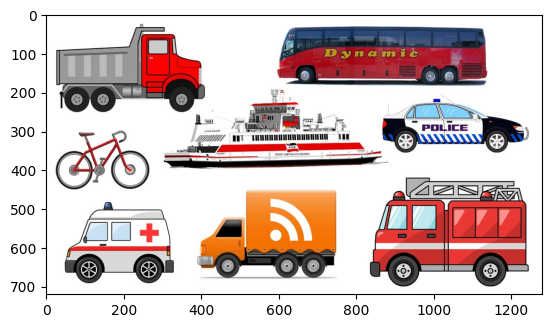

time: 480 ms (started: 2024-11-10 10:24:54 +00:00)


In [45]:
#@title B. Display Sample Image. You can modify the path and try your own images!
# change path here for another image
img = cv2.imread("/kaggle/working/OneFormer/samples/maxresdefault.jpg")
#img = imutils.resize(img, width=512)
plt.imshow(img[...,::-1])

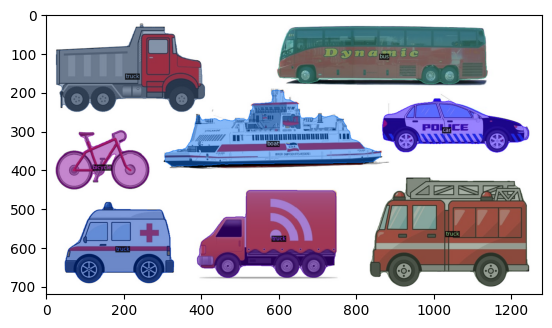

time: 1.56 s (started: 2024-11-10 10:24:57 +00:00)


In [46]:
#@title C. Run Inference (CPU)
task = "panoptic"
%reload_ext autotime
out = TASK_INFER[task](img, predictor, metadata).get_image()
plt.imshow(out[:, :, :])

In [47]:
def display_panoptic_predictions_info(predictions, metadata):
    # Trích xuất thông tin từ dự đoán panoptic
    panoptic_seg, segments_info = predictions["panoptic_seg"]
    
    # Tạo từ điển để đếm số lượng đối tượng theo category_name
    category_count = {}

    # Lặp qua tất cả các đối tượng trong segments_info
    for i, segment in enumerate(segments_info):
        print(f"Predicted Object {i + 1}:")
        print(f"  Segment ID: {segment['id']}")
        print(f"  Category ID: {segment['category_id']}")
        
        # Kiểm tra xem đối tượng có phải là `thing` hay không
        isthing = segment['isthing']
        
        # Lấy tên danh mục dựa trên isthing
        if isthing:
            category_name = metadata.thing_classes[segment['category_id']]
            classes_type = "thing"
        else:
            category_name = metadata.stuff_classes[segment['category_id']]
            classes_type = "stuff"

        print(f"  Category_name: {category_name}")
        print(f"  Classes_type: {classes_type}")
        print(f"  isthing: {isthing}")
        
        # Cập nhật và lấy số đếm của từng category_name
        if category_name not in category_count:
            category_count[category_name] = 1
        else:
            category_count[category_name] += 1

        # Tạo label với số đếm
        label = f"{category_name}{category_count[category_name]}"
        print(f"  label: {label}")
        
        # Hiển thị tọa độ pixel của mask
        mask = (panoptic_seg == segment['id']).nonzero()
        mask_coords = [(int(coord[0]), int(coord[1])) for coord in mask]  # Danh sách các tọa độ pixel
        print(f"  Mask Pixel Coordinates (sample 10 points): {mask_coords[:10]}")  # Hiển thị mẫu 5 tọa độ đầu tiên

        # Chỉ tính và hiển thị bounding box cho `thing`
        if isthing:
            y_coords = [coord[0] for coord in mask_coords]
            x_coords = [coord[1] for coord in mask_coords]
            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)
            bbox = [x_min, y_min, x_max - x_min, y_max - y_min]  # [x_min, y_min, width, height]
            print(f"  Bounding Box: {bbox}")
        
        print()  # Thêm dòng trống cho đẹp

# Sau khi thực hiện inference, bạn có thể gọi hàm này
task = "panoptic"  # Chạy nhiệm vụ panoptic
predictions = predictor(img, task)
display_panoptic_predictions_info(predictions, metadata)


Predicted Object 1:
  Segment ID: 1
  Category ID: 8
  Category_name: boat
  Classes_type: thing
  isthing: True
  label: boat1
  Mask Pixel Coordinates (sample 10 points): [(195, 593), (195, 594), (195, 595), (195, 596), (195, 597), (196, 585), (196, 586), (196, 587), (196, 588), (196, 589)]
  Bounding Box: [306, 195, 557, 196]

Predicted Object 2:
  Segment ID: 2
  Category ID: 7
  Category_name: truck
  Classes_type: thing
  isthing: True
  label: truck1
  Mask Pixel Coordinates (sample 10 points): [(453, 525), (453, 526), (453, 527), (453, 528), (453, 529), (453, 530), (453, 531), (453, 532), (453, 533), (453, 534)]
  Bounding Box: [390, 453, 358, 224]

Predicted Object 3:
  Segment ID: 3
  Category ID: 2
  Category_name: car
  Classes_type: thing
  isthing: True
  label: car1
  Mask Pixel Coordinates (sample 10 points): [(219, 1002), (219, 1003), (219, 1004), (219, 1005), (219, 1006), (219, 1007), (219, 1008), (219, 1009), (219, 1010), (219, 1011)]
  Bounding Box: [868, 219, 377, 

In [26]:
def display_panoptic_predictions_info(predictions, metadata):
    # Trích xuất thông tin từ dự đoán panoptic
    panoptic_seg, segments_info = predictions["panoptic_seg"]
    
    # Tạo từ điển để đếm số lượng đối tượng theo category_name
    category_count = {}

    # Tính kích thước của mask cho từng segment
    for segment in segments_info:
        mask = (panoptic_seg == segment['id']).nonzero()
        segment['size'] = len(mask[0])  # Lưu kích thước mask (số lượng điểm ảnh)
    
    # Sắp xếp danh sách segments_info theo các tiêu chí đã đưa ra
    sorted_segments = sorted(
        segments_info,
        key=lambda s: (not s['isthing'], metadata.thing_classes[s['category_id']] if s['isthing'] else metadata.stuff_classes[s['category_id']], -s['size'])
    )

    # Duyệt qua các đối tượng đã sắp xếp
    for i, segment in enumerate(sorted_segments):
        print(f"Predicted Object {i + 1}:")
        print(f"  Segment ID: {segment['id']}")
        print(f"  Category ID: {segment['category_id']}")
        
        # Kiểm tra xem đối tượng có phải là `thing` hay không
        isthing = segment['isthing']
        
        # Lấy tên danh mục dựa trên isthing
        if isthing:
            category_name = metadata.thing_classes[segment['category_id']]
            classes_type = "thing"
        else:
            category_name = metadata.stuff_classes[segment['category_id']]
            classes_type = "stuff"

        print(f"  Category_name: {category_name}")
        print(f"  Classes_type: {classes_type}")
        print(f"  isthing: {isthing}")
        
        # Cập nhật và lấy số đếm của từng category_name
        if category_name not in category_count:
            category_count[category_name] = 1
        else:
            category_count[category_name] += 1

        # Tạo label với số đếm
        label = f"{category_name}{category_count[category_name]}"
        print(f"  label: {label}")
        
        # Hiển thị tọa độ pixel của mask
        mask_coords = [(int(coord[0]), int(coord[1])) for coord in (panoptic_seg == segment['id']).nonzero()] 
        print(f"  Mask Pixel Coordinates (sample 10 points): {mask_coords[:10]}")

        # Chỉ tính và hiển thị bounding box cho `thing`
        if isthing:
            y_coords = [coord[0] for coord in mask_coords]
            x_coords = [coord[1] for coord in mask_coords]
            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)
            bbox = [x_min, y_min, x_max - x_min, y_max - y_min]  # [x_min, y_min, width, height]
            print(f"  Bounding Box: {bbox}")
        
        print()  # Thêm dòng trống cho đẹp

# Sau khi thực hiện inference, bạn có thể gọi hàm này
task = "panoptic"  # Chạy nhiệm vụ panoptic
predictions = predictor(img, task)
display_panoptic_predictions_info(predictions, metadata)


Predicted Object 1:
  Segment ID: 7
  Category ID: 2
  Category_name: car
  Classes_type: thing
  isthing: True
  label: car1
  Mask Pixel Coordinates (sample 10 points): [(323, 222), (323, 223), (323, 224), (323, 225), (323, 226), (323, 230), (323, 231), (323, 232), (323, 233), (323, 234)]
  Bounding Box: [139, 323, 224, 97]

Predicted Object 2:
  Segment ID: 4
  Category ID: 3
  Category_name: motorcycle
  Classes_type: thing
  isthing: True
  label: motorcycle1
  Mask Pixel Coordinates (sample 10 points): [(245, 118), (246, 115), (246, 116), (246, 117), (246, 118), (246, 119), (247, 113), (247, 114), (247, 115), (247, 116)]
  Bounding Box: [88, 245, 94, 55]

Predicted Object 3:
  Segment ID: 6
  Category ID: 3
  Category_name: motorcycle
  Classes_type: thing
  isthing: True
  label: motorcycle2
  Mask Pixel Coordinates (sample 10 points): [(345, 524), (346, 522), (346, 523), (346, 524), (346, 525), (346, 526), (346, 527), (346, 533), (346, 534), (347, 521)]
  Bounding Box: [452, 34

In [27]:
from collections import defaultdict

def display_panoptic_predictions_info(predictions, metadata):
    # Trích xuất thông tin từ dự đoán panoptic
    panoptic_seg, segments_info = predictions["panoptic_seg"]
    
    # Tạo từ điển để đếm số lượng đối tượng theo tên danh mục
    category_count = defaultdict(int)

    # Tính kích thước của mask và thêm `category_name` vào từng segment
    for segment in segments_info:
        mask_coords = (panoptic_seg == segment['id']).nonzero()
        segment['size'] = len(mask_coords[0])  # Lưu kích thước mask (số lượng điểm ảnh)
        if segment['isthing']:
            segment['category_name'] = metadata.thing_classes[segment['category_id']]
        else:
            segment['category_name'] = metadata.stuff_classes[segment['category_id']]

    # Sắp xếp các đối tượng
    sorted_segments = sorted(
        segments_info,
        key=lambda s: (
            s['category_name'],               # Sắp xếp theo tên danh mục
            not s['isthing'],                  # `thing` trước `stuff`
            -s['size'] if s['isthing'] else s['size']  # `thing` từ lớn đến nhỏ, `stuff` từ nhỏ đến lớn
        )
    )

    # Duyệt qua các đối tượng đã sắp xếp
    for i, segment in enumerate(sorted_segments):
        print(f"Predicted Object {i + 1}:")
        print(f"  Segment ID: {segment['id']}")
        print(f"  Category ID: {segment['category_id']}")
        
        # Lấy tên danh mục và loại đối tượng
        category_name = segment['category_name']
        isthing = segment['isthing']
        classes_type = "thing" if isthing else "stuff"

        print(f"  Category_name: {category_name}")
        print(f"  Classes_type: {classes_type}")
        
        # Đếm số lượng từng loại đối tượng
        category_count[category_name] += 1

        # Tạo nhãn với số đếm
        label = f"{category_name}{category_count[category_name]}"
        print(f"  Label: {label}")
        
        # Lấy tọa độ pixel của mask
        mask_coords = [(int(coord[0]), int(coord[1])) for coord in (panoptic_seg == segment['id']).nonzero()]
        print(f"  Mask Pixel Coordinates (sample 10 points): {mask_coords[:10]}")
        
        # Chỉ tính và hiển thị bounding box cho `thing`
        if isthing:
            y_coords, x_coords = zip(*mask_coords)
            bbox = [min(x_coords), min(y_coords), max(x_coords) - min(x_coords), max(y_coords) - min(y_coords)]
            print(f"  Bounding Box: {bbox}")
        
        print()  # Thêm dòng trống cho đẹp

# Sau khi thực hiện inference, bạn có thể gọi hàm này
task = "panoptic"  # Chạy nhiệm vụ panoptic
predictions = predictor(img, task)
display_panoptic_predictions_info(predictions, metadata)


Predicted Object 1:
  Segment ID: 7
  Category ID: 2
  Category_name: car
  Classes_type: thing
  Label: car1
  Mask Pixel Coordinates (sample 10 points): [(323, 222), (323, 223), (323, 224), (323, 225), (323, 226), (323, 230), (323, 231), (323, 232), (323, 233), (323, 234)]
  Bounding Box: [139, 323, 224, 97]

Predicted Object 2:
  Segment ID: 3
  Category ID: 91
  Category_name: house
  Classes_type: stuff
  Label: house1
  Mask Pixel Coordinates (sample 10 points): [(25, 297), (25, 298), (25, 299), (25, 300), (25, 301), (25, 302), (25, 303), (25, 304), (26, 295), (26, 296)]

Predicted Object 3:
  Segment ID: 4
  Category ID: 3
  Category_name: motorcycle
  Classes_type: thing
  Label: motorcycle1
  Mask Pixel Coordinates (sample 10 points): [(245, 118), (246, 115), (246, 116), (246, 117), (246, 118), (246, 119), (247, 113), (247, 114), (247, 115), (247, 116)]
  Bounding Box: [88, 245, 94, 55]

Predicted Object 4:
  Segment ID: 6
  Category ID: 3
  Category_name: motorcycle
  Classes

In [18]:
# Chạy inference để lấy đầu ra của mô hình với task "panoptic"
output = predictor(img, task="panoptic")

# Kiểm tra xem 'panoptic_seg' có trong output không
if "panoptic_seg" in output:
    panoptic_seg, segments_info = output["panoptic_seg"]

    # In từng segment với category_id và segment_id
    print("Danh sách tất cả category_id và segment_id:")
    for segment in segments_info:
        category_id = segment["category_id"]
        segment_id = segment["id"]  # Dùng segment_id để phân biệt các nhãn cùng lớp
        print(f"category_id: {category_id}, segment_id: {segment_id}")
else:
    print("Output không chứa 'panoptic_seg'. Vui lòng kiểm tra cấu trúc của output.")


Danh sách tất cả category_id và segment_id:
category_id: 0, segment_id: 1
category_id: 0, segment_id: 2
category_id: 91, segment_id: 3
category_id: 3, segment_id: 4
category_id: 100, segment_id: 5
category_id: 3, segment_id: 6
category_id: 2, segment_id: 7
category_id: 116, segment_id: 8
category_id: 3, segment_id: 9
category_id: 0, segment_id: 10
category_id: 0, segment_id: 11
category_id: 119, segment_id: 12
time: 668 ms (started: 2024-11-05 07:49:07 +00:00)


In [27]:
# Lấy thing_classes và stuff_classes từ metadata
thing_classes = metadata.thing_classes if hasattr(metadata, "thing_classes") else []
stuff_classes = metadata.stuff_classes if hasattr(metadata, "stuff_classes") else []

# In danh sách category_id của thing_classes và stuff_classes
print("Category ID của Thing Classes và Stuff Classes:\n")
print("{:<20} {:<20}".format("Thing Classes", "Stuff Classes"))

# Xác định số lượng hàng tối đa
max_len = max(len(thing_classes), len(stuff_classes))

# In từng category_id và tên lớp tương ứng
for i in range(max_len):
    thing = f"{i} - {thing_classes[i]}" if i < len(thing_classes) else ""
    stuff = f"{i} - {stuff_classes[i]}" if i < len(stuff_classes) else ""
    print("{:<20} {:<20}".format(thing, stuff))


Category ID của Thing Classes và Stuff Classes:

Thing Classes        Stuff Classes       
0 - person           0 - person          
1 - bicycle          1 - bicycle         
2 - car              2 - car             
3 - motorcycle       3 - motorcycle      
4 - airplane         4 - airplane        
5 - bus              5 - bus             
6 - train            6 - train           
7 - truck            7 - truck           
8 - boat             8 - boat            
9 - traffic light    9 - traffic light   
10 - fire hydrant    10 - fire hydrant   
11 - stop sign       11 - stop sign      
12 - parking meter   12 - parking meter  
13 - bench           13 - bench          
14 - bird            14 - bird           
15 - cat             15 - cat            
16 - dog             16 - dog            
17 - horse           17 - horse          
18 - sheep           18 - sheep          
19 - cow             19 - cow            
20 - elephant        20 - elephant       
21 - bear            21 - b

In [20]:
# Kiểm tra các thuộc tính của metadata để tìm thêm thông tin
print("Các thuộc tính có trong metadata:", dir(metadata))

Các thuộc tính có trong metadata: ['_RENAMED', '__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'as_dict', 'evaluator_type', 'get', 'ignore_label', 'image_root', 'json_file', 'label_divisor', 'name', 'panoptic_json', 'panoptic_root', 'sem_seg_root', 'set', 'stuff_classes', 'stuff_colors', 'stuff_dataset_id_to_contiguous_id', 'thing_classes', 'thing_colors', 'thing_dataset_id_to_contiguous_id']
time: 676 µs (started: 2024-11-05 07:53:58 +00:00)


# More Information on OneFormer 🎗️
- [Project Page](https://praeclarumjj3.github.io/oneformer/)
- [GitHub Repo](https://SHI-Labs/OneFormer)
- [ArXiv preprint](https://arxiv.org/abs/2211.06220)

In [11]:
import numpy as np
import torch
import pandas as pd
import torchvision
import os
import glob
import random
import torch.nn as nn
import torch.utils.data as data
import scipy.misc as S

from torchvision import datasets,models
from torchvision.transforms import functional as F
from torchvision import transforms as T
from torch import nn, optim
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict,deque
import datetime
import math
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageEnhance
import torchvision.transforms as transforms
import cv2
from typing_extensions import Concatenate
from skimage.transform import resize
from collections import Counter

# bbox and mask predictors
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

time: 373 ms (started: 2024-11-10 09:07:27 +00:00)


In [12]:
import torch

# Load mô hình đã được lưu trực tiếp từ file
model_path = '/kaggle/input/carpart_seg_maskrcnn/pytorch/default/1/mask-rcnn-car_seg.pt'
model = torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Chuyển mô hình sang chế độ đánh giá
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Định nghĩa các nhãn lớp
CLASS_NAMES = ['__background__', 'car', 'wheel', 'lights', 'window']


time: 2.64 s (started: 2024-11-10 09:07:33 +00:00)


In [13]:
def color_mask(mask):
    # defining 5 colors for segmentation
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0]]
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    r[mask == 1], g[mask == 1], b[mask == 1] = colours[random.randrange(0,5)]
    coloured_mask = np.stack([r, g, b], axis=2) #stacking along channel axis
    return coloured_mask

def predict(img_path, confidence):
    
    img = Image.open(img_path)
    convert_tensor = transforms.ToTensor()

    img = convert_tensor(img)

    img = img.to(device)
    pred = model([img])
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class

def visualize_predictions(img_path, confidence=0.5, rect_th=2, text_size=2, text_th=2):

    masks, boxes, pred_cls = predict(img_path, confidence)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(masks)):
      rgb_mask = color_mask(masks[i])
      img = cv2.addWeighted(img, 1, rgb_mask, 0.6, 0)
      boxes[i][0] = [int(i) for i in boxes[i][0]]
      boxes[i][1] = [int(i) for i in boxes[i][1]]
      
      cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
      cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    plt.figure(figsize=(40,40))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

time: 2.79 ms (started: 2024-11-10 09:08:03 +00:00)


In [14]:
!wget https://media.colomio.com/how-to-draw/car-drawing-kids-6.jpg

--2024-11-10 09:08:13--  https://media.colomio.com/how-to-draw/car-drawing-kids-6.jpg
Resolving media.colomio.com (media.colomio.com)... 104.18.42.227, 172.64.145.29, 2606:4700:4400::6812:2ae3, ...
Connecting to media.colomio.com (media.colomio.com)|104.18.42.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71970 (70K) [image/jpeg]
Saving to: ‘car-drawing-kids-6.jpg’

car-drawing-kids-6. 100%[===================>]  70.28K  --.-KB/s    in 0.01s   

2024-11-10 09:08:13 (5.63 MB/s) - ‘car-drawing-kids-6.jpg’ saved [71970/71970]

time: 1.38 s (started: 2024-11-10 09:08:12 +00:00)


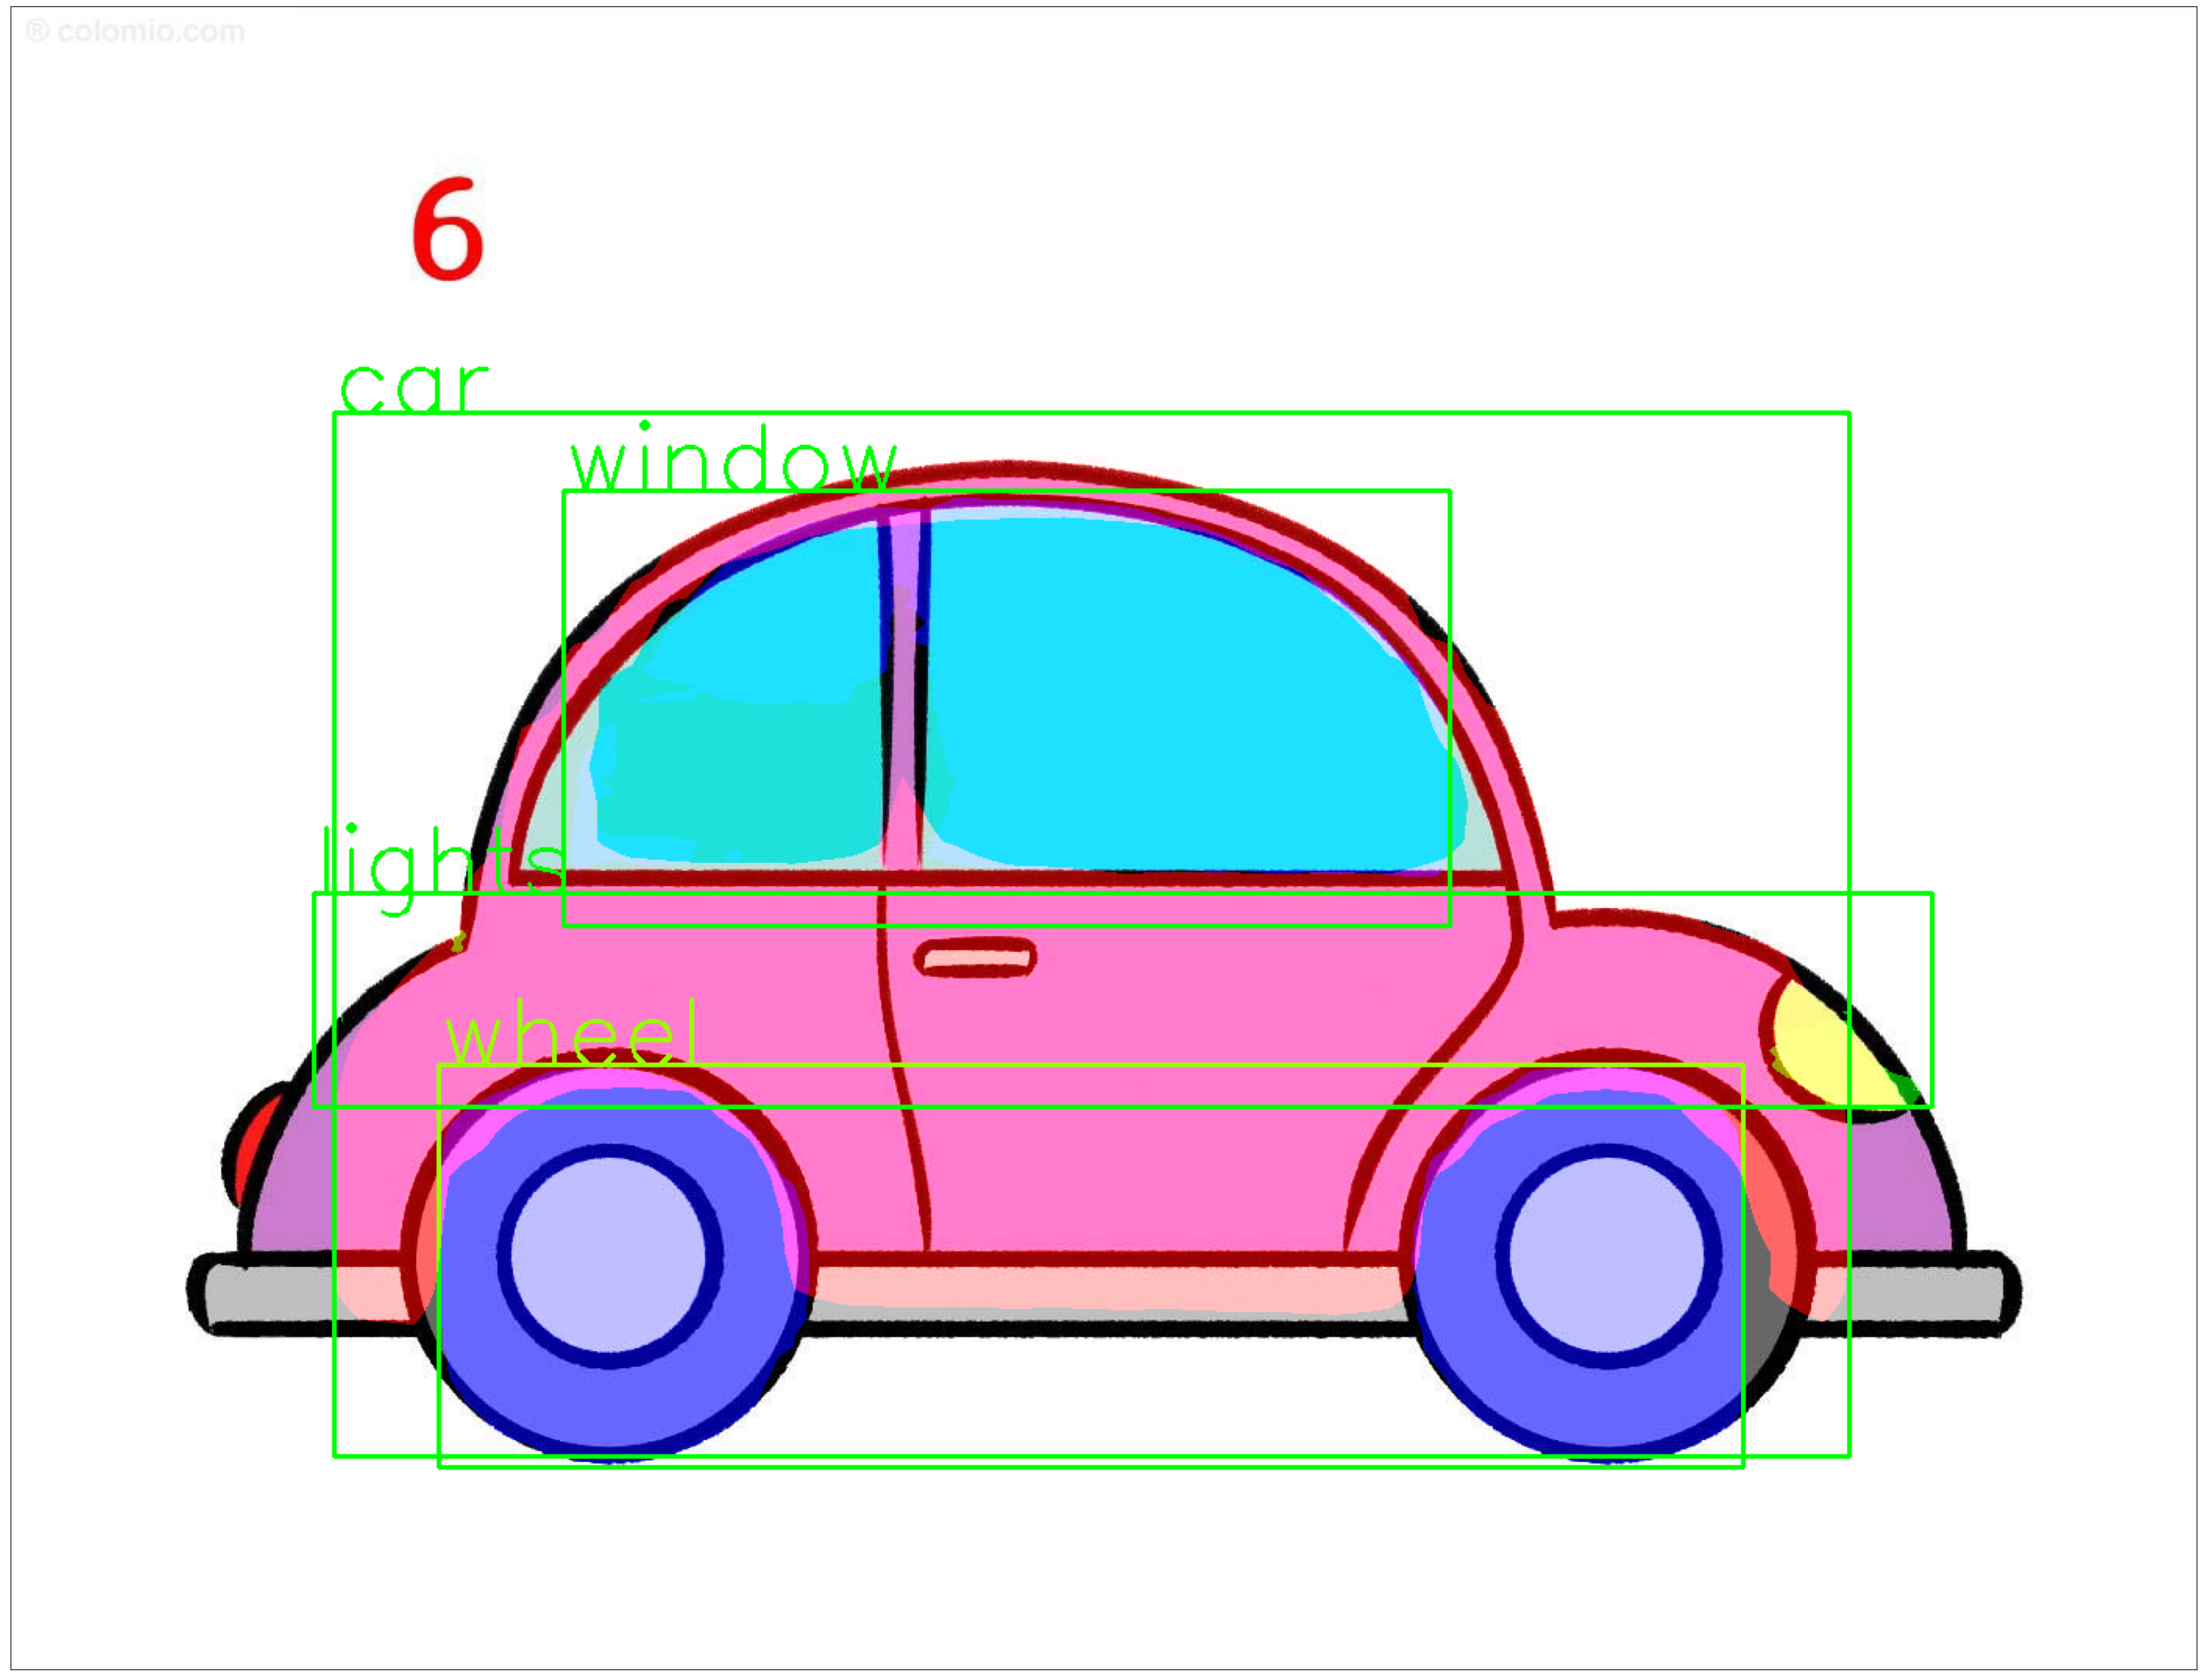

time: 2.44 s (started: 2024-11-10 09:51:39 +00:00)


In [28]:
visualize_predictions('/kaggle/working/OneFormer/car-drawing-kids-6.jpg', confidence=0.5)

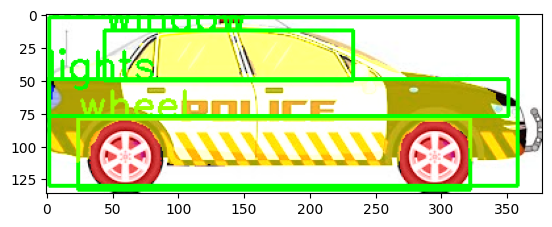

time: 3.61 s (started: 2024-11-10 10:26:00 +00:00)


In [48]:
import cv2
import numpy as np
import torch
import random
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# Load mô hình mới để phân đoạn bộ phận của xe
model_path = '/kaggle/input/carpart_seg_maskrcnn/pytorch/default/1/mask-rcnn-car_seg.pt'
model = torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Định nghĩa nhãn lớp cho mô hình mới
CLASS_NAMES = ['__background__', 'car', 'wheel', 'lights', 'window']

def color_mask(mask):
    colours = [[0, 255, 0], [0, 0, 255], [255, 0, 0], [0, 255, 255], [255, 255, 0]]
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    r[mask == 1], g[mask == 1], b[mask == 1] = colours[random.randrange(0, 5)]
    return np.stack([r, g, b], axis=2)

def predict_parts(cropped_img, confidence):
    convert_tensor = transforms.ToTensor()
    img_tensor = convert_tensor(cropped_img).to(device)
    pred = model([img_tensor])

    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = [i for i, score in enumerate(pred_score) if score > confidence]
    if not pred_t:
        return [], [], []
    
    masks = (pred[0]['masks'] > 0.5).squeeze().detach().cpu().numpy()
    pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    return masks[:len(pred_t)], pred_boxes[:len(pred_t)], pred_class[:len(pred_t)]

def process_car_objects(predictions, metadata, original_image, confidence=0.5):
    panoptic_seg, segments_info = predictions["panoptic_seg"]

    for segment in segments_info:
        category_id = segment['category_id']
        if segment['isthing'] and metadata.thing_classes[category_id] == 'car':
            mask = (panoptic_seg == segment['id']).nonzero()
            y_coords = [coord[0] for coord in mask]
            x_coords = [coord[1] for coord in mask]
            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)

            cropped_img = original_image[y_min:y_max, x_min:x_max]
            masks, boxes, pred_classes = predict_parts(cropped_img, confidence)

            for i in range(len(masks)):
                rgb_mask = color_mask(masks[i])
                cropped_img = cv2.addWeighted(cropped_img, 1, rgb_mask, 0.6, 0)
                cv2.rectangle(cropped_img, boxes[i][0], boxes[i][1], color=(0, 255, 0), thickness=2)
                cv2.putText(cropped_img, pred_classes[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), thickness=2)

            plt.imshow(cropped_img)
            plt.show()

# Sau khi chạy dự đoán panoptic:
original_image = cv2.imread('/kaggle/working/OneFormer/samples/maxresdefault.jpg')  # Thay bằng đường dẫn ảnh của bạn
process_car_objects(predictions, metadata, original_image, confidence=0.5)
